In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm 
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid

from zennit.composites import EpsilonPlusFlat
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names, abs_norm
from crp.attribution import CondAttribution
from collections import Counter

from tigramite import plotting as tp
import json

In [3]:
from expbasics.network import train_network
from expbasics.biased_dsprites_dataset import get_dataset, get_biased_loader
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution
%reload_ext autoreload
%autoreload 2

{0: Counter({False: 236537, True: 9223}), 1: Counter({True: 236541, False: 9219})}
cpu
../clustermodels/fine_b0i9_s0i5_l0i016.pickle


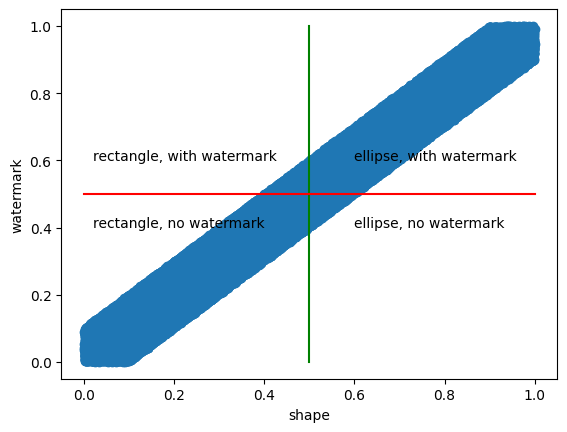

In [144]:
BIAS = 0.9
STRENGTH = 0.5
BATCH_SIZE = 128
LR = 0.009
NAME = "../clustermodels/nmf"

train_loader = get_biased_loader(
    BIAS, 0.5, batch_size=BATCH_SIZE, verbose=False
)
model = train_network(
    train_loader,
    BIAS,
    STRENGTH,
    NAME,
    BATCH_SIZE,
    load=True,
    retrain=False,
    learning_rate=LR,
    epochs=1,
)


In [118]:
composite = EpsilonPlusFlat()
cc = ChannelConcept()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
tdev = torch.device(device)
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

gm = GroundTruthMeasures(binary=True)

# neuron_flips = gm.compute_multiple_neuron_flips(model, "bbox")
# image = gm.load_image(300000, True)

In [246]:
import pickle
with open("small_res.json", "r") as f:
        items = json.load(f)
grids = []

for akey in items.keys():
    item = items[akey]
    for path in item["images"]:
        with open(f"{path}.pickle", "rb") as f:
            grid = pickle.load(f)
            grids.append([item["bias"], grid])

In [276]:
with open("all_results.json", "r") as f:
    analysis_data = json.load(f)
    
data = sorted(analysis_data.values(), key=lambda x: x["bias"])
ground_truths = [a["prediction_flip"] for a in data]
biases = [a["bias"] for a in  data]

In [275]:
""" with open("all_res.json", "r") as f:
    all_data = json.load(f)
with open("results_cluster.json", "r") as f:
    results_cluster = json.load(f)
with open("small_res.json", "r") as f:
    small_res = json.load(f)
with open("test_res.json", "r") as f:
    test_res = json.load(f)
first_el = list(all_data.keys())[0]
all_data_keys = list(all_data[first_el].keys())
keys_results_cluster = results_cluster[first_el].keys()
keys_small_res = small_res[first_el].keys()
keys_test_res = test_res[first_el].keys()
all_other_keys = list(keys_results_cluster) + list(keys_small_res) #+ list(keys_test_res)
filtered = [k for k in all_other_keys if k not in all_data_keys]
print(filtered)


for akey in all_data.keys():
    item = all_data[akey]
    item["images"] = small_res[akey]["images"]
    item["vmax_min"] = small_res[akey]["vmax_min"]
    all_data[akey] = item

with open("all_results.json", "w") as f:
    json.dump(all_data, f, indent=2) """

['images', 'vmax_min']


Text(0.5, 1.0, 'Bias: 1.0')

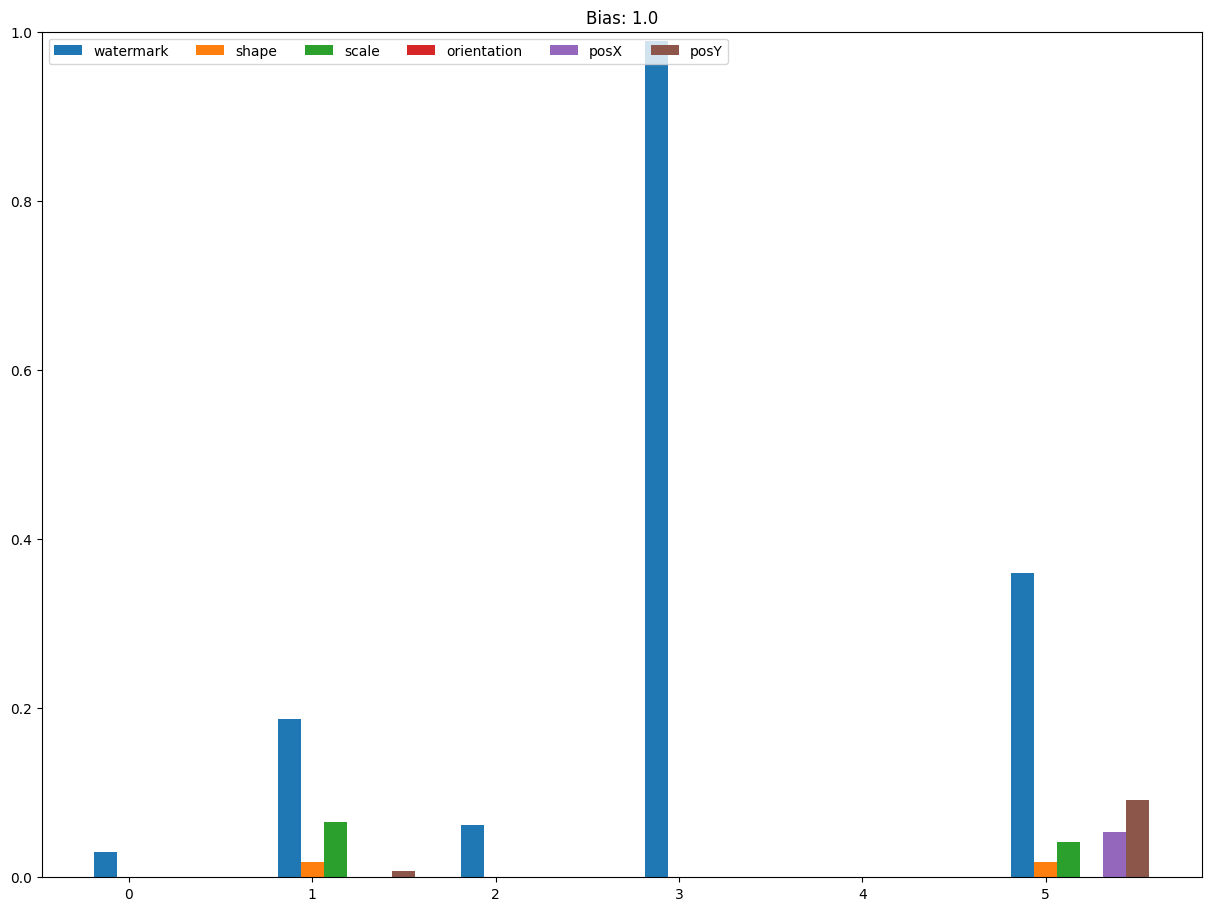

In [277]:
bias = "1.0"

least_squares_vals = analysis_data[f'b{bias}-s0_5-l0_02']["least_squares_vals"]

width = 1/8  # the width of the bars
multiplier = 0
names = ["watermark", "shape", "scale", "orientation", "posX", "posY"]
fig, ax = plt.subplots(layout='constrained',figsize=(12,9))
x = np.arange(6)
for measurement in least_squares_vals:
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=names[multiplier])
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, range(6))
ax.set_ylim(0, 1)
ax.legend(loc='upper left', ncols=6)
ax.set_title(f"Bias: {bias}")

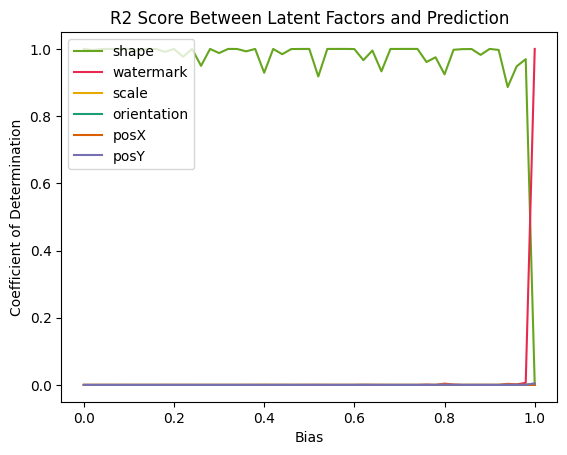

In [101]:
COLORS = ['#e72950','#66a61e','#e6ab02','#1b9e77','#d95f02','#7570b3',]

prediction_r2 = [a["prediction_r2"] for a in data]

def plot_pred_flip():
    keys = list(ground_truths[0].keys())
    
    for i in [1,0,2,3,4,5]:
        k = keys[i]
        color = COLORS[i]
        lat_data = [a[i] for a in prediction_r2]
        plt.plot(biases, lat_data, c=color, label=k)
    plt.legend(loc="upper left")
    plt.ylabel("Coefficient of Determination")
    plt.xlabel("Bias")
    plt.title("R2 Score Between Latent Factors and Prediction")
plot_pred_flip()

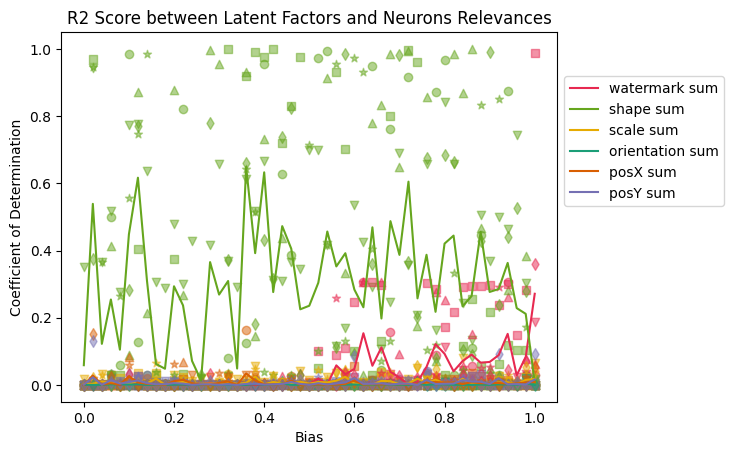

In [102]:
COLORS = [
    "#e72950",
    "#66a61e",
    "#e6ab02",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]
neuron_data = [a["least_squares_vals"] for a in data]
styles = ["solid", "dotted", "dashed", "dashdot", (0, (1, 1)), (0, (3, 5, 1, 5))]
marker_styles = ["o", "v", "^", "s", "*", "d"]


def plot_pred_flip():
    keys = list(ground_truths[0].keys())
    for n in range(6):
        for i in range(6):
            k = keys[i]
            color = COLORS[i]
            lat_data = [a[i][n] for a in neuron_data]
            plt.scatter(
                biases,
                lat_data,
                c=color,
                marker=marker_styles[n], # type: ignore
                alpha=0.5,
            )
    for i in range(6):
        k = keys[i]
        color = COLORS[i]
        sum_data = [sum([a[i][n] for n in range(6)]) / 6 for a in neuron_data]
        plt.plot(biases, sum_data, c=color, label=f"{k} sum", linestyle="solid")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 0.9))
    plt.title("R2 Score between Latent Factors and Neurons Relevances")
    plt.xlabel("Bias")
    plt.ylabel("Coefficient of Determination")


plot_pred_flip()

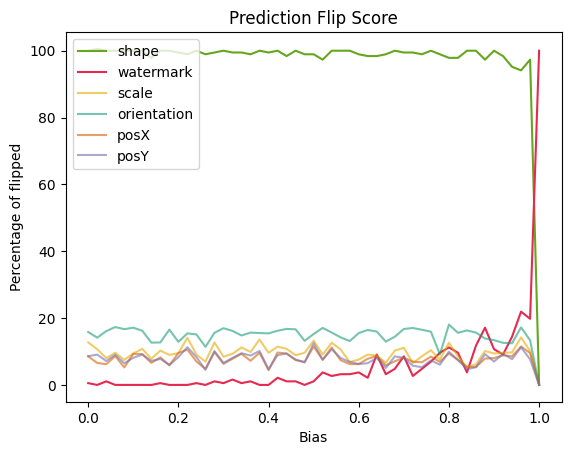

In [103]:
COLORS = ['#e72950','#66a61e','#e6ab0299','#1b9e7799','#d95f0299','#7570b399',]
def plot_pred_flip():
    keys = list(ground_truths[0].keys())
    
    for i in [1,0,2,3,4,5]:
        k = keys[i]
        color = COLORS[i]
        lat_data = [a[k]*100 for a in ground_truths]
        plt.plot(biases, lat_data, c=color, label=k)
    plt.legend(loc="upper left")
    plt.ylabel("Percentage of flipped")
    plt.xlabel("Bias")
    plt.title("Prediction Flip Score")
plot_pred_flip()

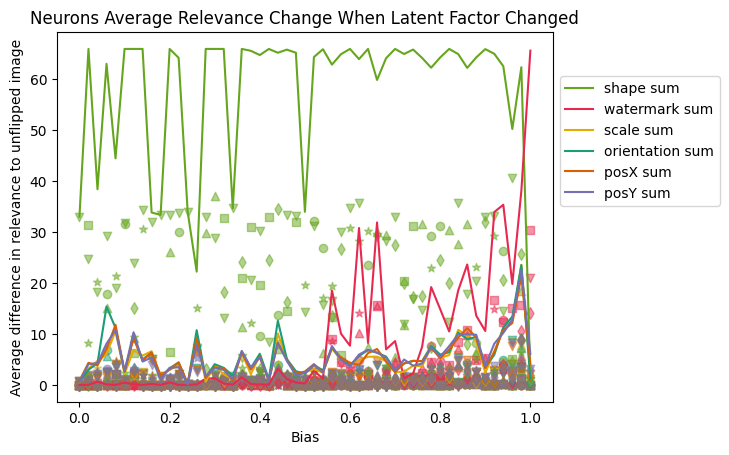

In [260]:
COLORS = [
    "#e72950",
    "#66a61e",
    "#e6ab02",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]
neuron_data = [a["neuron_flips_simple"] for a in data]


def plot_pred_flip():
    keys = list(neuron_data[0].keys())
    for n in range(6):
        neuron_name = f"linear_layers.0_{n}"
        for i in range(6):
            k = keys[i]
            color = COLORS[i]
            lat_data = [a[k][neuron_name] for a in neuron_data]
            plt.scatter(
                biases,
                lat_data,
                c=color,
                alpha=0.5,
                marker=marker_styles[n],  # type: ignore
            )

    for i in [1, 0, 2, 3, 4, 5]:
        k = keys[i]
        color = COLORS[i]
        sum_data = [
            sum([a[k][f"linear_layers.0_{i}"] for i in range(6)]) for a in neuron_data
        ]
        plt.plot(biases, sum_data, c=color, label=f"{k} sum")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 0.9))
    plt.ylabel("Average difference in relevance to unflipped image")
    plt.xlabel("Bias")
    plt.title(f"Neurons Average Relevance Change When Latent Factor Changed")


plot_pred_flip()

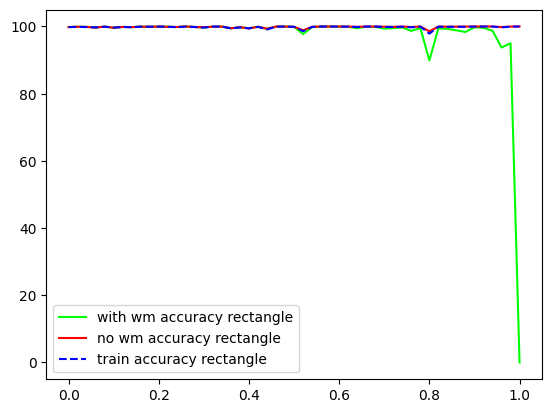

In [17]:
def plot_accs(shape):
    label = "rectangle" if shape == 0 else "ellipse"
    plt.plot(biases, [a["all_wm_accuracy"][shape] for a in  data], c="#0f0", label=f"with wm accuracy {label}")
    plt.plot(biases, [a["no_wm_accuracy"][shape] for a in  data], c="#f00", label=f"no wm accuracy {label}")
    plt.plot(biases, [a["train_accuracy"][shape] for a in  data], c="#00f", label=f"train accuracy {label}", linestyle="dashed")
    plt.legend(loc="lower left")
plot_accs(0)

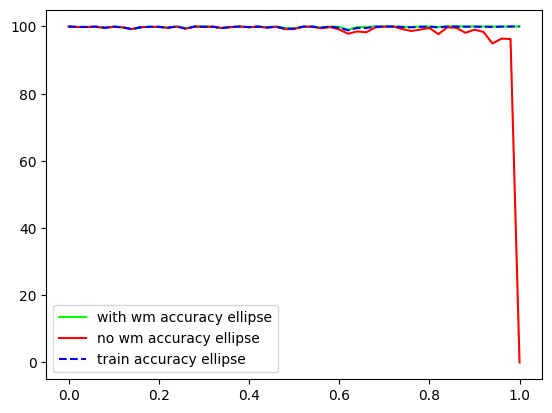

In [18]:
plot_accs(1)

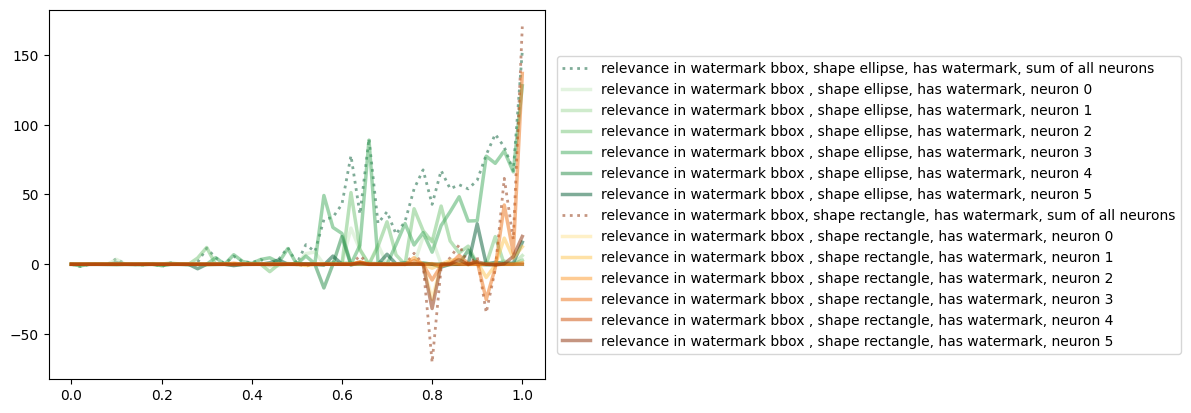

In [50]:
REC_HUES = ["#fee391","#fec44f","#fe9929","#ec7014","#cc4c02","#8c2d04"]
ELL_HUES = ['#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#005a32']


def plot_linear_layer(shape, box="wm", has_wm="0"):
    label = "rectangle" if shape == "0" else "ellipse"
    wm_label = "has watermark" if has_wm == "1" else "no watermark"
    box_label = "in watermark bbox" if box == "wm" else "rest of image"
    colors = REC_HUES if shape == "0" else ELL_HUES
    plt.plot(
        biases,
        [
            np.sum(
                [
                    a["watermark_mask_concepts"][shape][has_wm][f"linear_layers.0_{x}"][
                        box
                    ]
                    for x in range(6)
                ]
            )
            for a in data
        ],
        c=colors[-1],
        label=f"relevance {box_label}, shape {label}, {wm_label}, sum of all neurons",
        linestyle="dotted",linewidth=2,alpha=0.5
    )
    for i in range(6):
        plt.plot(
            biases,
            [
                a["watermark_mask_concepts"][shape][has_wm][f"linear_layers.0_{i}"][box]
                for a in data
            ],
            c=colors[i],
            label=f"relevance {box_label} , shape {label}, {wm_label}, neuron {i}",
            alpha=0.5, linewidth=2.5
        )
    plt.legend(loc="lower left", bbox_to_anchor=(1.01, 0.05))


plot_linear_layer("1", "wm", "1")
plot_linear_layer("0", "wm", "1")

Text(0.5, 0, 'Bias')

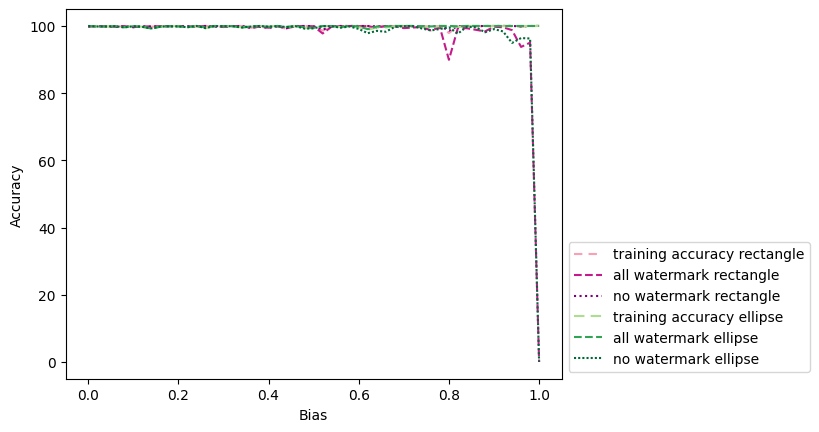

In [59]:
rcol = ['#fa9fb5','#f768a1','#c51b8a','#7a0177']
ecol= ['#addd8e','#78c679','#31a354','#006837']
plt.plot(biases, [a["train_accuracy"][0] for a in  data], c=rcol[0], label=f"training accuracy rectangle", linestyle=(0,(4,3)))
plt.plot(biases, [a["all_wm_accuracy"][0] for a in  data], c=rcol[2], label=f"all watermark rectangle", linestyle="dashed")
plt.plot(biases, [a["no_wm_accuracy"][0] for a in  data], c=rcol[3], label=f"no watermark rectangle", linestyle="dotted")
plt.plot(biases, [a["train_accuracy"][1] for a in  data], c=ecol[0], label=f"training accuracy ellipse", linestyle=(0,(5,3)))
plt.plot(biases, [a["all_wm_accuracy"][1] for a in  data], c=ecol[2], label=f"all watermark ellipse", linestyle="dashed")
plt.plot(biases, [a["no_wm_accuracy"][1] for a in  data], c=ecol[3], label=f"no watermark ellipse", linestyle=(0,(1,1)))
plt.legend(loc="lower left", bbox_to_anchor=(1, 0))
plt.ylabel("Accuracy")
plt.xlabel("Bias")